In [1]:
import glob

import numpy as np
import pandas as pd
from Levenshtein import distance
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import cut_tree, fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from tqdm.auto import tqdm

# This notebook contains pHLA:TCR curation and EDA
1. Prepare data and filter
  1. Publications
  1. Databases
  1. 10x
  1. Zhang 
1. Remove duplicates
1. Peptides hierarchical clustering

# Prepare and filter

## Data from publications (w/o Zhang)

In [2]:
datasets = {}
for d in sorted(glob.glob("../../data/processed/*input.csv.gz")):
    df = pd.read_csv(d)
    # JK: modified -> error earlier
    if "dataset" in df.columns:
        df.loc[:, "dataset_index"] = df.dataset + "_" + np.arange(len(df)).astype(str)
        datasets[df.dataset.iloc[0]] = df
    else:
        print("No dataset column in", d)  # No dataset column in Carey

No dataset column in ../../data/processed/carey_input.csv.gz


In [3]:
datasets.keys()

dict_keys(['Attaf', 'Miconnet', 'Cukalac', 'Arakaki', 'gee2018', 'Hakeem', 'huth', 'Kamga', 'Malekzadeh', 'Pogorelyy', 'Soon', 'Takeda'])

### Concat and filter

In [4]:
publications = pd.concat(list(datasets.values()))

In [5]:
publications.index = np.arange(len(publications))

In [6]:
print(publications.shape[0], "observations before filtering")

9028 observations before filtering


In [7]:
publications.dataset.value_counts().head(10)

Pogorelyy    5968
huth         1052
Hakeem        324
Miconnet      250
Kamga         221
Price         183
Cukalac       176
Venturi       168
Hanley         86
Wang           54
Name: dataset, dtype: int64

In [8]:
publications.fillna("NA").peptide_source.value_counts()

YFV                          5968
CMV                          2153
EBV                           332
HCV                           324
InfluenzaA                    176
colorectal adenocarcinoma      33
lung cancer                    20
HEV                            13
epithelial cancer               9
Name: peptide_source, dtype: int64

### Mice TCRs

In [9]:
publications.tcr_source_organism.fillna("NA").value_counts()

human            8852
C57BL/6J mice     176
Name: tcr_source_organism, dtype: int64

### HLA type is NA for mice data

In [10]:
pd.crosstab(publications.HLA_type.isna(), publications.tcr_source_organism)

tcr_source_organism,C57BL/6J mice,human
HLA_type,,
False,0,8852
True,176,0


### MHC_type is not NA for mice data

In [11]:
publications.MHC_type.value_counts()

H-2Db    176
Name: MHC_type, dtype: int64

### Peptides and tissue source

In [12]:
publications.tissue.value_counts()

PBMC           8807
spleen          176
TIL              42
whole blood       3
Name: tissue, dtype: int64

In [13]:
publications.peptide_seq.value_counts().head(10)

LLWNGPMAV      5968
NLVPMVATV       646
CRVLCCYVL       435
TPRVTGGGAM      354
FRCPRRFCF       266
RPHERNGFTVL     213
GLCTLVAML       159
ARMILMTHF       138
YVLDHLIVV       128
CINGVCWTV       120
Name: peptide_seq, dtype: int64

In [14]:
# JK: 75 unique peptides
publications.peptide_seq.unique().shape

(78,)

### Normalize MHC names

In [15]:
new_hla_type = (
    publications.HLA_type.str.replace("HLA-", "", regex=False)
    .str.replace(":", "", regex=False)
    .str.replace("*", "", regex=False)
)

In [16]:
publications.HLA_type = new_hla_type

In [17]:
publications.HLA_type.value_counts()

A02         6603
C0702        701
A0201        434
B0702        397
B07          174
B27          138
A2           120
B35           79
A1            66
B0801         45
A24           25
A2402         20
B08           14
A01            9
B18            9
A6801          3
B4403          3
DR3            3
DRB30202       2
B12            1
DQ6            1
DQ11           1
DRB11301       1
DRB10401       1
DPB10201       1
DR13           1
Name: HLA_type, dtype: int64

### First filter: 
1. Human
1. MHCI
1. CD3Rb is not NA
1. CDR3b and peptide contain only standard 20 aa

In [18]:
AA_list = [
    "A",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "V",
    "W",
    "Y",
]

In [19]:
publications.peptide_seq.apply(lambda x: all([xx in AA_list for xx in x]) if not isinstance(x, float) else False).all()

True

In [20]:
publications.CDR3b = publications.CDR3b.str.upper()

In [21]:
df_human_mhci_cdr3b = publications[
    (publications.tcr_source_organism == "human")
    & (~publications.HLA_type.fillna("NA").str.startswith("D"))
    & (~publications.CDR3b.isna())
    & (publications.CDR3b.fillna("NA").apply(lambda x: all([xx in AA_list for xx in x])))
    & (
        publications.peptide_seq.apply(
            lambda x: all([xx in AA_list for xx in x]) if not isinstance(x, float) else False
        )
    )
]

In [22]:
print(df_human_mhci_cdr3b.shape[0], "observations")

8745 observations


### First and last CDR3b anchor positions C and F

In [23]:
df_human_mhci_cdr3b.CDR3b.str[0].value_counts()

C    8604
S      95
R      15
G       6
P       5
A       4
E       3
T       3
D       2
N       2
H       2
L       2
Q       1
I       1
Name: CDR3b, dtype: int64

In [24]:
df_human_mhci_cdr3b.loc[df_human_mhci_cdr3b.CDR3b.str[0] != "C", "dataset"].value_counts()

Wang         54
Nguyen       44
Klinger      16
Iancu         9
Pogorelyy     7
Peggs         6
Venturi       2
Kamga         2
huth          1
Name: dataset, dtype: int64

### Missing first anchor, looks like garbage

In [25]:
df_human_mhci_cdr3b.loc[df_human_mhci_cdr3b.CDR3b.str[0] != "C", "CDR3b"].sample(10)

721     GDSALYFCASTLLGGAGYNEQFFGPGTRLTV
940                         SLPPGRGYTEA
725     PSQTSVYFCASSYATGASYGYTFGSGTRLTV
1342                         SYKTGTALGY
967                SLQAGANEQFFGPGTRLTVL
1331                         SPVGSFADTQ
1333                       SRDTSGRARNTQ
1303                          GRGGMIGEQ
1297                      RATSREGPNQPQH
1335                          SSGALNTEA
Name: CDR3b, dtype: object

### Missing last anchor, looks ok

In [26]:
df_human_mhci_cdr3b.loc[df_human_mhci_cdr3b.CDR3b.str[-1] != "F", "CDR3b"].sample(19)

1233           CASSSAHYGYT
515            CASSSANYGYT
6219       CASSKLAGGSYEQYV
1140           CANSSANYGYT
1229        CASSQADRAVYGYT
258            CSTQEGGYGYT
607             RLLAGGRSAQ
684         CASSYSTAGELFFG
1365        CASSPARNTEAFFG
495     CASSSHDYRGRRSPLHFG
1135       CAGSQEQGPGNQPQH
1137           CAGSSAYYGYT
1288        CSLKSSGNSSYEQY
1235           CASSSANYGYT
6337       CASSFDRFLIYEQYV
972        CANSYATGIGNYGYT
1342            SYKTGTALGY
7839            CAPWAYEQYV
1314              SEWADTEA
Name: CDR3b, dtype: object

In [27]:
v1 = (df_human_mhci_cdr3b.CDR3b.str[0] == "C").values
v2 = (df_human_mhci_cdr3b.CDR3b.str[-1] == "F").values

In [28]:
pd.crosstab(v1, v2, dropna=False)

col_0,False,True
row_0,,
False,133,8
True,501,8103


### Second filter: 
1. CDR3b[0] == 'C'

In [29]:
df_human_mhci_cdr3b_anchors = df_human_mhci_cdr3b[df_human_mhci_cdr3b.CDR3b.str[0] == "C"]

### Length

In [30]:
df_human_mhci_cdr3b_anchors.CDR3b.str.len().isin(np.arange(10, 21)).mean().round(
    3
) * 100, "% between CDR3b length 10 and 20"

(99.6, '% between CDR3b length 10 and 20')

In [31]:
df_human_mhci_cdr3b_anchors.peptide_seq.str.len().value_counts().sort_index()

8       57
9     7954
10     371
11     221
12       1
Name: peptide_seq, dtype: int64

In [32]:
# Only one peptide over 11 AA

### Third filter: 
1. peptide length in [8-11]
1. CDR3b length in [10-20]

In [33]:
df_human_mhci_cdr3b_anchors_length = df_human_mhci_cdr3b_anchors[
    df_human_mhci_cdr3b_anchors.peptide_seq.str.len().isin([8, 9, 10, 11])
    & df_human_mhci_cdr3b_anchors.CDR3b.str.len().isin(np.arange(10, 21))
]

In [34]:
df_human_mhci_cdr3b_anchors_length.shape[0], "observations"

(8567, 'observations')

In [35]:
# publications_df = df_human_mhci_cdr3b_anchors_length

### Combine all filters into a single function


In [36]:
def filter_tcr(databases):
    databases.CDR3b = databases.CDR3b.str.upper()
    databases_filtered = databases[
        (databases.tcr_source_organism == "human")
        & (databases.HLA_type.str.contains("^(A|B|C)"))
        & (~databases.CDR3b.isna())
        & databases.peptide_seq.str.len().isin([8, 9, 10, 11])
        & databases.CDR3b.str.len().isin(np.arange(10, 21))
        & (databases.CDR3b.str[0] == "C")
        & (databases.CDR3b.apply(lambda x: all([xx in AA_list for xx in x]) if not isinstance(x, float) else False))
        & (
            databases.peptide_seq.apply(
                lambda x: all([xx in AA_list for xx in x]) if not isinstance(x, float) else False
            )
        )
    ]
    databases_filtered.index = np.arange(len(databases_filtered))
    return databases_filtered

In [37]:
publications_filtered = filter_tcr(publications)

<ipython-input-36-38537a903742>:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  & (databases.HLA_type.str.contains("^(A|B|C)"))


In [38]:
publications_df = publications_filtered

In [39]:
len(df_human_mhci_cdr3b_anchors_length), len(publications_filtered)

(8567, 8567)

In [40]:
print(publications_filtered.shape[0], "observations after filtering")

8567 observations after filtering


# Data from TCR databases

In [41]:
mcpas = pd.read_csv("../../data/processed/mcpas_tcr_final.csv.gz")
mcpas.loc[:, "dataset"] = "McPAS"

In [42]:
vdjdb = pd.read_csv("../../data/processed/vdj_final.csv.gz")
vdjdb.loc[:, "dataset"] = "VDJdb"

/home/ardigen/miniconda3/envs/keras2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
tbadb = pd.read_csv("../../data/processed/tba_final.csv.gz")
tbadb.loc[:, "dataset"] = "TBAdb"

### 10x data in VDJdb is questionable. They report ~15k binders, but I've found ~11k following the instructions in the manual. 
See https://pages.10xgenomics.com/rs/446-PBO-704/images/10x_AN047_IP_A_New_Way_of_Exploring_Immunity_Digital.pdf


In [44]:
vdj_tenx = vdjdb[vdjdb.tcr_reference == vdjdb.tcr_reference.value_counts().index[0]]

In [45]:
vdj_tenx.shape

(34486, 20)

In [46]:
vdj_tenx.CDR3b.unique().shape

(15507,)

### Save the vdj_tenx for later analysis and remove it from the vdjdb dataframe

In [47]:
vdjdb = vdjdb[vdjdb.tcr_reference != vdjdb.tcr_reference.value_counts().index[0]]

In [48]:
vdjdb.shape

(24352, 20)

In [49]:
vdjdb.sample(3)

,peptide_seq,HLA_type,CDR3a,CDR3b,peptide_source,peptide_gene,MHC_class,TRAV,TRBV,TRAJ,TRBJ,tcr_source_organism,tissue,experiment_type,single_cell,sequencing,tcr_reference,vdj_CDR3fix,vdj_score,dataset
28995,GPGHKARVL,B07:02,NaN,CATRSTDTQYF,HIV-1,Gag,I,NaN,15*01,NaN,2-3*01,human,PBMC,multimer-sort,NaN,sanger,PMID:21555537,"{""cdr3"": ""CATRSTDTQYF"", ""cdr3_old"": ""CATRSTDTQ...",1,VDJdb
26952,CINGVCWTV,A02,NaN,CASTSQSELFF,HCV,NS3,I,NaN,6-1*01,NaN,1-4*01,human,PBMC,tetramer-sort,NaN,amplicon-seq,PMID:28146579,"{""cdr3"": ""CASTSQSELFF"", ""cdr3_old"": ""CASTSQSEL...",1,VDJdb
29359,MLNIPSINV,A02,NaN,CAWSVASTGLNYEQYF,CMV,pp65,I,NaN,30*01,NaN,2-7*01,human,NaN,tetramer-sort,NaN,sanger,PMID:25925682,"{""cdr3"": ""CAWSVASTGLNYEQYF"", ""cdr3_old"": ""CAWS...",1,VDJdb


In [50]:
mcpas.peptide_seq.value_counts().head(5)

LPRRSGAAGA    2142
GILGFVFTL     1791
GLCTLVAML      980
NLVPMVATV      814
SSYRRPVGI      588
Name: peptide_seq, dtype: int64

In [51]:
mcpas.sample(3)

,peptide_seq,HLA_type,CDR3a,CDR3b,peptide_source,MHC_class,TRAV,TRBV,TRAJ,TRBJ,...,single_cell,mcpas_ngs,tissue,category,mcpas_mouse_strain,tcr_reference,additional_study_details,mcpas_reconstructed_j_annotation,mcpas_remarks,dataset
3526,ASNENMETM,H-2Kb,CAMRGNSGTYQRF,CASSGGANTGQLYF,Influenza,I,16D/DV11:02,13-1,1-01,2-2:01,...,yes,yes,Bronchoalveolar,pathogens,C57/BL6,PMID:28636592,NaN,no,NaN,McPAS
4203,SSPPMFRV,H-2Kb,CAASMGNYNVLYF,CASSPDWGGYAEQFF,mCMV,I,7-2:02,4-01,2-01,2-1:01,...,yes,yes,Spleen,pathogens,C57/BL6,PMID:28636592,NaN,no,NaN,McPAS
11568,RPHERNGFTVL,B07:02,NaN,CATGTGDSNQPQHF,Cytomegalovirus (CMV),I,NaN,10-3,NaN,1-5,...,no,yes,PBMC,pathogens,NaN,PMID:30587531,NaN,NaN,NaN,McPAS


### Concat VDJdb, McPAS and TBAdb and filter

In [52]:
databases = pd.concat([mcpas, vdjdb, tbadb])

In [53]:
databases.CDR3b.isna().value_counts()

False    39322
True      6190
Name: CDR3b, dtype: int64

**Fix HLA types**

In [54]:
databases.HLA_type.value_counts().head(50)

A02          14952
A02:01        6942
H-2Kb         2895
H-2Db         2580
A2            2296
B7            2177
Mamu-A01      1337
B07:02        1192
B42:01         942
DRA01          723
C07:02         701
DRA01:01       647
A01:01         541
A24:02         527
B08:01         501
DRB104-01      477
B27:05         466
A11:01         430
B08            424
H-2b           362
B57:01         358
DRA101         334
B35:01         314
A1             305
B27            217
A68:01         215
DR5            202
A-A01:01       201
DQ8            151
DR15           150
DQ2            149
DR11           143
B57:03         133
B57            120
H-2Kd          117
B44             79
B35:08          76
A03:01          67
A11             62
DR1             60
DRB104:01       55
B07             51
B44:03:08       49
A02:01:48       47
A03             42
A-B08:01        42
B15             41
B81:01          40
A01             36
B51:01          36
Name: HLA_type, dtype: int64

In [55]:
databases.HLA_type = (
    databases.HLA_type.str.replace("HLA-", "", regex=False)
    .str.replace(":", "", regex=False)
    .str.replace("*", "", regex=False,)
    .str.replace("A-", "", regex=False)
)

In [56]:
databases[databases.HLA_type.str.contains("-")].dataset.value_counts()

VDJdb    4987
McPAS    2935
Name: dataset, dtype: int64

In [57]:
databases.HLA_type[databases.HLA_type.str.len() == 2].value_counts()

A2    2296
B7    2177
A1     305
B8       3
Name: HLA_type, dtype: int64

In [58]:
databases.HLA_type = (
    databases.HLA_type.replace("B7", "B07").replace("A1", "A01").replace("A2", "A02").replace("B8", "B08")
)

In [59]:
databases.HLA_type.value_counts().head(50)

A02          17248
A0201         6961
H-2Kb         2895
H-2Db         2580
B07           2228
Mamu-A01      1337
B0702         1192
B4201          942
A0101          742
DRA01          723
C0702          701
DRA0101        647
B0801          543
A2402          527
DRB104-01      477
B2705          466
B08            447
A1101          430
H-2b           362
B5701          358
A01            341
DRA101         334
B3501          314
B27            217
A6801          215
DR5            202
DQ8            151
DR15           150
DQ2            149
DR11           143
B5703          133
B57            120
H-2Kd          117
B44             79
B3508           76
A0301           67
A11             62
DR1             60
DRB10401        55
B440308         49
A020148         47
A03             42
B15             41
B8101           40
B5101           36
DRB1            32
DPB10201        28
H-2bxH-2z       25
H-2u            21
DQA10501        21
Name: HLA_type, dtype: int64

In [60]:
databases.shape

(45512, 35)

In [61]:
# Source organism
databases.tcr_source_organism.value_counts()

human    42866
mouse     2602
Name: tcr_source_organism, dtype: int64

In [62]:
databases.HLA_type.str.contains("^(A|B|C)").value_counts()

<ipython-input-62-8bde32569ecf>:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  databases.HLA_type.str.contains("^(A|B|C)").value_counts()


True     34808
False    10704
Name: HLA_type, dtype: int64

In [63]:
databases.shape[0], "obs before filtering"

(45512, 'obs before filtering')

In [64]:
databases.CDR3b = databases.CDR3b.str.upper()

**First filter:**
1. Human
1. Valid HLA
1. Has CDR3b

In [65]:
databases_filtered = databases[
    (databases.tcr_source_organism == "human")
    & (databases.HLA_type.str.contains("^(A|B|C)"))
    & (~databases.CDR3b.isna())
    & (databases.CDR3b.fillna("NA").apply(lambda x: all([xx in AA_list for xx in x])))
    & (databases.peptide_seq.apply(lambda x: all([xx in AA_list for xx in x]) if not isinstance(x, float) else False))
]

<ipython-input-65-f4f44979661b>:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  & (databases.HLA_type.str.contains("^(A|B|C)"))


### Anchor positions

In [66]:
databases_filtered.CDR3b.str[0].value_counts()

C    30411
G        4
R        3
W        3
K        1
L        1
M        1
Name: CDR3b, dtype: int64

In [67]:
databases_filtered.CDR3b.str[-1].value_counts()

F    30339
Y       27
T       22
L       15
V        6
S        5
C        3
H        2
W        2
A        1
I        1
G        1
Name: CDR3b, dtype: int64

**Second filter:** 
1. CDR3b[0] == 'C'

In [68]:
databases_filtered.loc[databases_filtered.CDR3b.str[-1] != "F", "CDR3b"].sample(10)

5689           CASSQSPGGTQYL
5934         CASSQDFRGGYEQYS
447            CASSPDRARDGYT
5892            CAWSRGAVEQFL
2507         CASSPRDRDFNYGYT
428               CASSGQGGYT
2502            CASSPIQGSEQY
9172         CASSQDGGTSGGGQI
5446        CASSWSGGGARDTQDV
1426    CAISERAIRGTSGLTDTQYL
Name: CDR3b, dtype: object

In [69]:
databases_filtered = databases_filtered[databases_filtered.CDR3b.str[0] == "C"]

In [70]:
databases_filtered.shape

(30411, 35)

In [71]:
databases_filtered.peptide_seq.str.len().value_counts().sort_index()

8       870
9     22490
10     5878
11      988
12      122
13       17
15       14
20       32
Name: peptide_seq, dtype: int64

In [72]:
databases_filtered.CDR3b.str.len().isin(np.arange(10, 21)).mean() * 100

99.53635197790274

**Third filter:** 
1. peptide length in [8-11]
1. CDR3b length in [10-20]

In [73]:
databases_filtered = databases_filtered[
    databases_filtered.peptide_seq.str.len().isin([8, 9, 10, 11])
    & databases_filtered.CDR3b.str.len().isin(np.arange(10, 21))
]

In [74]:
databases_filtered.index = np.arange(len(databases_filtered))

In [75]:
databases_filtered.CDR3b.unique().shape[0], "unique CDR3b"

(18842, 'unique CDR3b')

In [76]:
databases_filtered.CDR3b.value_counts().head(5)

CASSIRSSYEQYF    134
CASSIRSAYEQYF     69
CASSQSPGGTQYF     44
CASSVRSSYEQYF     37
CASSSANYGYTF      32
Name: CDR3b, dtype: int64

**The filtering above was exploratory and was intended to demonstrate what we filtered out. 
The filtering function is used below in order to have a consistent filtering procedure.**

In [77]:
databases_filtered_2 = filter_tcr(databases)
databases_df = databases_filtered_2

<ipython-input-36-38537a903742>:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  & (databases.HLA_type.str.contains("^(A|B|C)"))


In [78]:
print("Databases obs before filtering", len(databases))

Databases obs before filtering 45512


In [79]:
print("Databases obs after filtering", len(databases_df))

Databases obs after filtering 30085


In [80]:
databases.CDR3b = databases.CDR3b.str.upper()

databases_filtered_2_b = filter_tcr(databases)
databases_df_b = databases_filtered_2_b

print("Databases obs after filtering", len(databases_df_b))

<ipython-input-36-38537a903742>:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  & (databases.HLA_type.str.contains("^(A|B|C)"))


Databases obs after filtering 30085


In [81]:
databases.CDR3a.value_counts()

CAVSGNYAQGLTF      82
CAVSANYAQGLTF      76
CAVSDNYAQGLTF      66
CAGGGSQGNLIF       52
CAGAGGGSQGNLIF     41
                   ..
CAMRGEEGSQGNLIF     1
CAVNSYYNQGGKLIF     1
CAVQDLQTSGSRLTF     1
CAVQSLETSGSRLTF     1
CIVRVWDAGNNF        1
Name: CDR3a, Length: 5342, dtype: int64

In [82]:
# JK: Probably a bugged annotation in 2 cases
(databases.CDR3a == databases.CDR3b).value_counts()

False    45510
True         2
dtype: int64

## Compare duplicates in publications and databases


In [83]:
def make_id(databases_filtered):
    """
    return pd.Series with unique observation identifier: peptide_HLA_CDR3b
    """
    return databases_filtered.peptide_seq + "_" + databases_filtered.HLA_type + "_" + databases_filtered.CDR3b

In [84]:
publications_df.loc[:, "id"] = make_id(publications_df)

/home/ardigen/miniconda3/envs/keras2/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [85]:
databases_df.loc[:, "id"] = make_id(databases_df)

In [86]:
len(
    np.unique(np.concatenate([publications_df.id, databases_df.id]))
), "total unique observations in publications and databases"

(27769, 'total unique observations in publications and databases')

In [87]:
pub_ind_db = publications_df.id.isin(databases_df.id)

In [88]:
# Co-occurence of CDR3b in publications and databases
pd.crosstab(publications_df.dataset, pub_ind_db)

id,False,True
dataset,,
Arakaki,1,0
Brennan,42,0
Cohen,0,1
Day,21,0
Giest,0,10
Hakeem,186,138
Hamel,3,0
Hanley,1,85
Heemskerk,4,0


## 10x

In [89]:
def load_regeneron_10x(dataset_path, special_cases_path, threshold):
    
    dataset = pd.read_csv(dataset_path)
    dataset = dataset[dataset['Donor']!='Donor V']
    dataset = dataset.groupby(['pMHC', 'alpha_cdr3', 'beta_cdr3'])['normalized dex. Sig.'].median()
    dataset = dataset.reset_index()
    dataset = dataset[['pMHC', 'beta_cdr3', 'alpha_cdr3', 'normalized dex. Sig.']]
    
    dataset['HLA_type'] = dataset['pMHC'].apply(lambda x: x.split('_')[0]).str.replace('\*', '')
    dataset['peptide'] = dataset['pMHC'].apply(lambda x: x.split('_')[1])
    dataset['origin'] = dataset['pMHC'].apply(lambda x: 'Cancer' if 'Cancer' in x else 'Others')
    dataset['CDR3a'] = dataset['alpha_cdr3']
    dataset['CDR3b'] = dataset['beta_cdr3']
    dataset['value'] = dataset['normalized dex. Sig.']>threshold
    dataset = dataset[['peptide', 'HLA_type', 'CDR3a', 'CDR3b', 'value', 'origin']]
    
    maits_inkts = pd.read_csv(special_cases_path)        
    maits_inkts_mask = ~np.isin(dataset['CDR3a'], maits_inkts)
    dataset = dataset[maits_inkts_mask]
        
    return dataset

In [90]:
tenx = load_regeneron_10x('../../data/original/10x_regeneron.csv.gz',
                          '../../data/original/maits_inkts.csv.gz', 0)

<ipython-input-89-dec600aa593b>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['HLA_type'] = dataset['pMHC'].apply(lambda x: x.split('_')[0]).str.replace('\*', '')


In [91]:
tenx = tenx[tenx.value]

In [92]:
tenx.head(3)

,peptide,HLA_type,CDR3a,CDR3b,value,origin
0,ELAGIGILTV,A0201,CAADNARLMF,CASSIASLLAGGTDTQYF,True,Cancer
1,ELAGIGILTV,A0201,CAAGAGSYQLTF,CASSQGQGQPQHF,True,Cancer
2,ELAGIGILTV,A0201,CAANAGNMLTF,CASSLGGGTEAFF,True,Cancer


In [93]:
tenx.shape

(4515, 6)

In [94]:
# Extract VDJ peptide infor for every peptide in 10x dataset from vdj
vdj_peptide_info = vdj_tenx.groupby("peptide_seq")[
    [
        "peptide_gene",
        "peptide_source",
        "MHC_class",
        "experiment_type",
        "single_cell",
        "tcr_reference",
        "tcr_source_organism",
    ]
].agg("first")

In [95]:
vdj_peptide_info.head()

,peptide_gene,peptide_source,MHC_class,experiment_type,single_cell,tcr_reference,tcr_source_organism
peptide_seq,,,,,,,
AVFDRKSDAK,EBNA4,EBV,I,dextramer-sort,yes,https://www.10xgenomics.com/resources/applicat...,human
AYAQKIFKI,IE1,CMV,I,dextramer-sort,yes,https://www.10xgenomics.com/resources/applicat...,human
CLLGTYTQDV,KanJ,StreptomycesKanamyceticus,I,dextramer-sort,yes,https://www.10xgenomics.com/resources/applicat...,human
CLLWSFQTSA,TYR,HomoSapiens,I,dextramer-sort,yes,https://www.10xgenomics.com/resources/applicat...,human
CYTWNQMNL,WT1,HomoSapiens,I,dextramer-sort,yes,https://www.10xgenomics.com/resources/applicat...,human


In [96]:
tenx.origin = tenx.origin.map({
    'Others': 'viral',
    'Cancer': 'Homo Sapiens'
})

In [97]:
tenx = tenx.rename(columns={
    'peptide': 'peptide_seq',
})

In [98]:
tenx_meta = vdj_peptide_info.reindex(tenx.peptide_seq)
tenx_meta.index = tenx.index

In [99]:
mask = tenx_meta.tcr_source_organism.isna()

In [100]:
mask.sum()

0

In [101]:
m = tenx.peptide_seq == 'CLGGLLTMV'

In [102]:
tenx_meta.loc[m, 'peptide_source'] =  'EBV'

tenx_meta.loc[m, 'MHC_class'] =  'I'
tenx_meta.loc[m, 'experiment_type'] =  'dextramer-sort'
tenx_meta.loc[m, 'single_cell'] =  'dextramer-sort'
tenx_meta.loc[m, 'tcr_reference'] =  vdj_peptide_info.tcr_reference.iloc[0]
tenx_meta.loc[:, 'tcr_source_organism'] =  'human'

In [103]:
tenx_meta.tcr_source_organism.isna().any()

False

In [104]:
tenx_full = pd.concat([tenx, tenx_meta], axis=1)

In [105]:
tenx_full.peptide_source.fillna('NA').value_counts()

CMV            2599
InfluenzaA      844
EBV             793
HomoSapiens     241
HTLV-1           16
HIV-1            16
HPV               6
Name: peptide_source, dtype: int64

In [106]:
tenx_full.loc[:, 'id'] = make_id(tenx)

In [107]:
tenx_full.head(3)

,peptide_seq,HLA_type,CDR3a,CDR3b,value,origin,peptide_gene,peptide_source,MHC_class,experiment_type,single_cell,tcr_reference,tcr_source_organism,id
0,ELAGIGILTV,A0201,CAADNARLMF,CASSIASLLAGGTDTQYF,True,Homo Sapiens,MLANA,HomoSapiens,I,dextramer-sort,yes,https://www.10xgenomics.com/resources/applicat...,human,ELAGIGILTV_A0201_CASSIASLLAGGTDTQYF
1,ELAGIGILTV,A0201,CAAGAGSYQLTF,CASSQGQGQPQHF,True,Homo Sapiens,MLANA,HomoSapiens,I,dextramer-sort,yes,https://www.10xgenomics.com/resources/applicat...,human,ELAGIGILTV_A0201_CASSQGQGQPQHF
2,ELAGIGILTV,A0201,CAANAGNMLTF,CASSLGGGTEAFF,True,Homo Sapiens,MLANA,HomoSapiens,I,dextramer-sort,yes,https://www.10xgenomics.com/resources/applicat...,human,ELAGIGILTV_A0201_CASSLGGGTEAFF


In [108]:
tenx_full['id'].unique().shape

(3826,)

In [109]:
def join_unique(x):
    x = [str(xx) for xx in x]
    return '|'.join(list(sorted(set(x.astype(str)))))

tenx_grouped = tenx_full.groupby("id").agg(
            {
                "CDR3b": "first",
                "CDR3a": lambda x: '|'.join(sorted(set(x))),
                "peptide_seq": "first",
                "HLA_type": "first",
                'tcr_source_organism': 'first',
                'tcr_reference': 'first',
                'origin': 'first',
                'peptide_gene': 'first',
                'peptide_source': 'first', 
                'single_cell': 'first',
                'MHC_class': 'first',
                
            }
        )
tenx_grouped = tenx_grouped.reset_index()
tenx_grouped.loc[:, "dataset"] = "10x"

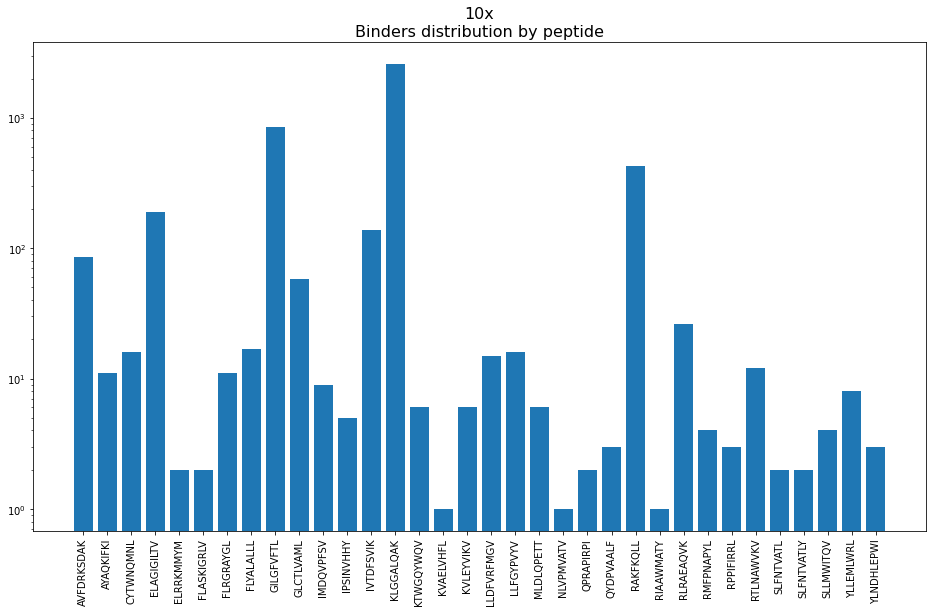

In [110]:
v = tenx_full["peptide_seq"].value_counts()

v = v[np.sort(v.index)]

plt.bar(np.arange(len(v)), v)
plt.gca().set_yscale("log")
plt.xticks(np.arange(len(v)), v.index, rotation=90)
plt.gcf().set_size_inches(16, 9)
plt.title("10x\nBinders distribution by peptide", fontsize=16)
plt.show()

In [111]:
tenx_grouped.loc[:, "dataset_index"] = "10x_" + pd.Series(np.arange(len(tenx_grouped)).astype(str), index=tenx_grouped.index)

In [112]:
tenx_grouped.loc[:, "id"] = make_id(tenx_grouped)

In [113]:
tenx_filtered = filter_tcr(tenx_grouped)

<ipython-input-36-38537a903742>:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  & (databases.HLA_type.str.contains("^(A|B|C)"))


In [114]:
print(len(tenx_grouped), "obs before filtering")

3826 obs before filtering


In [115]:
print(len(tenx_filtered), "obs after filtering")

3813 obs after filtering


In [116]:
# Reason for filtering - len(CDR3b) not between 10 and 20
tenx_grouped[~tenx_grouped.dataset_index.isin(tenx_filtered.dataset_index)].CDR3b.str.len().value_counts().sort_index()

7     1
8     1
9     3
21    6
22    2
Name: CDR3b, dtype: int64

### Split 10x dataset into viral and cancer parts

In [117]:
tenx_viral = tenx_filtered[tenx_filtered.peptide_source != "HomoSapiens"]
tenx_cancer = tenx_filtered[tenx_filtered.peptide_source == "HomoSapiens"]

In [118]:
tenx_cancer.dataset = "10x_cancer"
tenx_viral.dataset = "10x_viral"

/home/ardigen/miniconda3/envs/keras2/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [119]:
tenx_cancer.index = np.arange(len(tenx_cancer))
tenx_viral.index = np.arange(len(tenx_viral))

In [120]:
tenx_cancer.shape

(239, 14)



## Zhang

In [121]:
zhang = pd.read_csv("../../data/processed/zhang/zhang_input.csv.gz")

In [122]:
zhang.HLA_type.value_counts()

A02:01    1360
Name: HLA_type, dtype: int64

In [123]:
zhang.HLA_type = zhang.HLA_type.str.replace(":", "")

***After discussion with Paulina, the peptide source for unknown peptides 
was established to be TAA (gene name is available in the metadata)***

In [124]:
zhang.peptide_source = zhang.peptide_source.fillna("TAA")

In [125]:
zhang.loc[:, "dataset_index"] = "zhang2018_" + pd.Series(np.arange(len(zhang)).astype(str), index=zhang.index)

In [126]:
zhang_filtered = filter_tcr(zhang)

<ipython-input-36-38537a903742>:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  & (databases.HLA_type.str.contains("^(A|B|C)"))


In [127]:
zhang_filtered.loc[:, "id"] = make_id(zhang_filtered)

/home/ardigen/miniconda3/envs/keras2/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [128]:
print(len(zhang), "obs before filtering")

1360 obs before filtering


In [129]:
print(len(zhang_filtered), "obs after filtering")

1093 obs after filtering


### Analyze what has been filtered out and why

In [130]:
zhang_removed = zhang.loc[~zhang.dataset_index.isin(zhang_filtered.dataset_index)]

**258 observations removed due to missing CDR3b**

In [131]:
zhang_removed.CDR3b.isna().value_counts()

True     258
False      9
Name: CDR3b, dtype: int64

**9 observations are filtered due to other reasons**
1. no peptide sequence
2. too short CDR3b

In [132]:
zhang_removed[~zhang_removed.CDR3b.isna()]

,peptide_seq,HLA_type,CDR3a,CDR3b,peptide_name,wildtype,peptide_rank,peptide_source,peptide_reference,TRAV,TRBV,tcr_source_organism,cell_name,sorted_population,experiment_type,tetramer_fluorescence,no_experiment,dataset,dataset_index
110,KLSEGDLLA,A0201,NaN,CASDEKLFF,PD5-KLS,NaN,rank_1,TAA,NaN,NaN,6-1*01,human,BE11,Non-Naïve Endogenous,tetramer staining,PE,1,zhang2018,zhang2018_110
177,MLNIPSINV,A0201,CAVGMDSSYKLIF,CASNQPQHF,CMV-MLN,NaN,rank_1,virus,NaN,8-3,6-1,human,UE2,Foreign_Naive,tetramer staining,APC,2,zhang2018,zhang2018_177
344,MLNIPSINV,A0201,CVVSAMGGGNKLTF,CASNQPQHF,CMV-MLN,NaN,rank_1,virus,NaN,10,6-1,human,UE2,Foreign_Naive,tetramer staining,APC,2,zhang2018,zhang2018_344
430,NaN,A0201,CVVSPYNQGGKLIF,CASSLDIGDQPQHF,NaN,NaN,rank_1,TAA,NaN,12-1*01,7-9*01,human,CH6,Neo+WT+,tetramer staining,APC,3,zhang2018,zhang2018_430
431,NaN,A0201,CAYYGGGATNKLIF,CASSLGSGTQYF,NaN,NaN,rank_2,TAA,NaN,38-2/DV8*01,13*01,human,BF12,Neo+WT+,tetramer staining,APC,3,zhang2018,zhang2018_431
432,NaN,A0201,CAMREGNTGGFKTIF,CASSAGGDTEAFF,NaN,NaN,rank_3,TAA,NaN,14/DV4*01,9*01,human,BC8,Neo+WT+,tetramer staining,APC,3,zhang2018,zhang2018_432
760,FLTVFSHFM,A0201,CAVNSNYQLIW,CSGDAFF,PIGN-FLT_P7H,no,rank_1,NSCLC,Rizvi,12-2*01,20-1*01,human,JA5,Neo+WT-,tetramer staining,PE,5,zhang2018,zhang2018_760
871,RLGPYLEFL,A0201,CAYTSNDMRF,RASSPRTGGEQYF,ITIH6-RLG,yes,rank_1,NSCLC,Rizvi,38-2/DV8*01,7-4*01,human,MB5,Neo-WT+,tetramer staining,APC,5,zhang2018,zhang2018_871
973,SLDLTTSPV,A0201,NaN,RASSFTAPGLQYNEQFF,GOLGA3-SLD_P4L,no,rank_1,SKCM,Strønen,NaN,7-3*01,human,KG6,Neo+WT-,tetramer staining,PE,5,zhang2018,zhang2018_973


# Concat and remove duplicates

In [133]:
# tenx_viral = tenx_viral

In [134]:
df_all = pd.concat([publications_df, databases_df, tenx_cancer, tenx_viral, zhang_filtered], axis=0)

In [135]:
df_all.loc[:, "phla"] = df_all.peptide_seq + "_" + df_all.HLA_type

In [136]:
vc = df_all.dataset.value_counts()

**When removing duplicates, I retain only one row for every group of observations with identicaltical ids (peptide_HLA_CDR3b)**

**`priority_list` determines which observation is retained for every duplicate group.**
1. Zhang and 10x,
1. medium sized datasets, (100 - 1000 observations),
1. databases (over 1000 observations),
1. small datasets (less than 100 observations),


10x and Zhang are on the top of the list because of the high quality of the experiments and because 10x_cancer and Zhang are also test sets. Medium datasets are prioritized above databases because they provide large fairly homogenous subsets of observations; the authors often publish slightly different data than what we find in databases later. Databases are prioritized over small datasets because there is some homogeneity provided by the curation process of the database. 


In [137]:
# JK: 24% of duplicates
df_all.id.duplicated().sum() / len(df_all)

0.25334037375453416

In [138]:
df_all.id.value_counts().head(30)

GILGFVFTL_A0201_CASSIRSSYEQYF       99
GILGFVFTL_A0201_CASSIRSAYEQYF       50
GILGFVFTL_A02_CASSIRSSYEQYF         37
GILGFVFTL_A0201_CASSVRSSYEQYF       32
NLVPMVATV_A02_CASSQTQLWETQYF        26
GLCTLVAML_A0201_CASSQSPGGTQYF       26
GLCTLVAML_A0201_CSARDRTGNGYTF       24
NLVPMVATV_A0201_CASSSANYGYTF        23
GLCTLVAML_A0201_CSARDGTGNGYTF       22
GLCTLVAML_A02_CASSQSPGGTQYF         22
GILGFVFTL_A0201_CASSIRASYEQYF       22
RPRGEVRFL_B0702_CASSVWGTDTQYF       21
GILGFVFTL_A0201_CASSSRSSYEQYF       21
GLCTLVAML_A0201_CSVGTGGTNEKLFF      21
GILGFVFTL_A02_CASSIRSAYEQYF         20
GLCTLVAML_A0201_CSARDRVGNTIYF       19
GILGFVFTL_A0201_CASSIRSTGELFF       19
GILGFVFTL_A0201_CASSTRSSYEQYF       19
GLCTLVAML_A0201_CSARDSTGNGYTF       18
RPRGEVRFL_B0702_CATRIGWGTDTQYF      18
LLWNGPMAV_A0201_CASTPGQALNEQYF      17
GILGFVFTL_A0201_CASSGRSTDTQYF       17
GILGFVFTL_A0201_CASSTRSTDTQYF       17
GILGFVFTL_A0201_CASSIGVYGYTF        16
NLVPMVATV_A02_CASSLAPGATNEKLFF      16
NLVPMVATV_A02_CASSSVNEQFF

In [139]:
publications_df.dataset.value_counts().head()

Pogorelyy    5861
huth         1039
Hakeem        324
Miconnet      250
Kamga         217
Name: dataset, dtype: int64

In [140]:
priority_list = (
    ["zhang2018", "10x_cancer", "10x_viral"]
    + list(vc.index[(vc >= 100) & (vc < 1000)])
    + list(vc.index[vc >= 1000][::-1])
    + list(vc.index[vc < 100])
)

**Duplicates are dropped from `priority_list` because the zhang and 10x are contained twice due to being large datasets themselves.**

In [141]:
priority_list = list(pd.Series(priority_list).drop_duplicates())

In [142]:
df_all.dataset.unique()

array(['Miconnet', 'Price', 'Venturi', 'Lim', 'Iancu', 'Cohen', 'Miles',
       'Arakaki', 'Brennan', 'Day', 'Giest', 'Hamel', 'Hanley',
       'Heemskerk', 'Janbazian', 'Karenbeek', 'Khan', 'Klinger', 'Koning',
       'Liang', 'Nakasone', 'Retiere', 'Schub', 'Trautmann', 'vanBockel',
       'Weekes', 'Wynn', 'gee2018', 'Hakeem', 'huth', 'Kamga',
       'Malekzadeh', 'Pogorelyy', 'Soon', 'Takeda', 'McPAS', 'VDJdb',
       'TBAdb', '10x_cancer', '10x_viral', 'zhang2018'], dtype=object)

In [143]:
df_all.dataset.isna().sum()

0

In [144]:
np.setdiff1d(np.array(priority_list), df_all.dataset.unique())

array([], dtype='<U10')

In [145]:
# Just to make sure we don't miss anything
assert set(df_all.dataset.unique()) == set(priority_list)

In [146]:
priority_list[:15]

['zhang2018',
 '10x_cancer',
 '10x_viral',
 'Hakeem',
 'Miconnet',
 'Kamga',
 'Price',
 'Venturi',
 'huth',
 'TBAdb',
 'Pogorelyy',
 'McPAS',
 'VDJdb',
 'Hanley',
 'Koning']

In [147]:
# Medium datasets first, then databases, then small ones

In [148]:
vc.loc[priority_list].head(25)

zhang2018      1093
10x_cancer      239
10x_viral      3574
Hakeem          324
Miconnet        250
Kamga           217
Price           183
Venturi         165
huth           1039
TBAdb          5852
Pogorelyy      5861
McPAS          8482
VDJdb         15751
Hanley           86
Koning           50
Karenbeek        42
Brennan          42
Janbazian        38
vanBockel        36
gee2018          33
Trautmann        31
Nakasone         25
Day              21
Weekes           21
Takeda           20
Name: dataset, dtype: int64

In [149]:
def prioritize_db(phlatcr_df):
    this_priority_list = np.intersect1d(phlatcr_df.dataset, priority_list)
    for p in this_priority_list:
        mask = phlatcr_df.dataset == p
        if mask.any():
            return phlatcr_df[mask].iloc[0]
    return phlatcr_df.iloc[0]

In [150]:
df_all.sample(3)

,peptide_seq,HLA_type,CDR3a,TRAJ,TRAV,peptide_source,tcr_source_organism,tissue,experiment_type,dataset,...,origin,peptide_name,wildtype,peptide_rank,peptide_reference,cell_name,sorted_population,tetramer_fluorescence,no_experiment,phla
24065,YLQPRTFLL,A02,NaN,NaN,NaN,SARS-CoV-2,human,TCL,"cultured-T-cells,tetramer-sort",VDJdb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YLQPRTFLL_A02
7759,LLWNGPMAV,A02,NaN,NaN,NaN,YFV,human,PBMC,"dextramer-sort, TCRb seq",Pogorelyy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LLWNGPMAV_A02
7315,FRCPRRFCF,C0702,NaN,NaN,NaN,Cytomegalovirus (CMV),human,PBMC,pMHC tetramers,McPAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRCPRRFCF_C0702


In [151]:
df_all.peptide_source.value_counts()

CMV                                   14319
YFV                                    6270
InfluenzaA                             4140
Influenza                              3641
EBV                                    2788
Cytomegalovirus (CMV)                  2150
HomoSapiens                            1788
HIV-1                                  1773
Human immunodeficiency virus (HIV)     1359
Epstein Barr virus (EBV)               1037
HCV                                     829
NSCLC                                   409
HTLV-1                                  355
SARS-CoV-2                              344
Melanoma                                339
SKCM                                    251
Yellow fever virus                      248
YellowFeverVirus                        247
Hepatitis C virus                       190
TAA                                     174
DENV1                                   165
DENV3/4                                 158
virus                           

In [152]:
df_all.shape

(43558, 52)

In [153]:
df_unique = df_all.groupby("id").apply(prioritize_db)

In [154]:
df_all.shape

(43558, 52)

In [155]:
df_unique.shape

(32523, 52)

In [156]:
df_unique.dataset.value_counts().head(10)

VDJdb         8699
McPAS         7799
Pogorelyy     5623
TBAdb         4360
10x_viral     3574
zhang2018     1046
10x_cancer     239
Miconnet       171
Kamga          161
Price          142
Name: dataset, dtype: int64

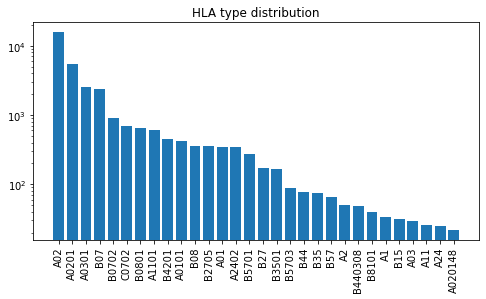

In [157]:
vc = df_unique.HLA_type.value_counts().head(30)
plt.bar(vc.index, vc)
plt.xticks(np.arange(len(vc)), vc.index, rotation=90)
plt.gca().set_yscale("log")
plt.gcf().set_size_inches(8, 4)
# plt.gca().set_yticks([10, 100, 1000])
plt.title("HLA type distribution")
plt.show()

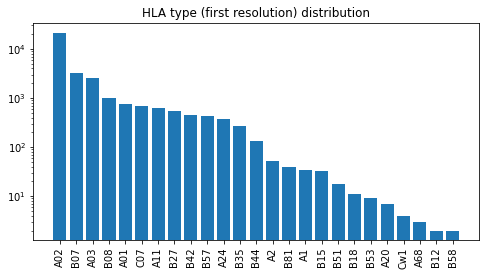

In [158]:
vc = df_unique.HLA_type.str[:3].value_counts().head(30)
plt.bar(vc.index, vc)
plt.xticks(np.arange(len(vc)), vc.index, rotation=90)
plt.gca().set_yscale("log")
plt.gcf().set_size_inches(8, 4)
# plt.gca().set_yticks([10, 100, 1000])
plt.title("HLA type (first resolution) distribution")
plt.show()

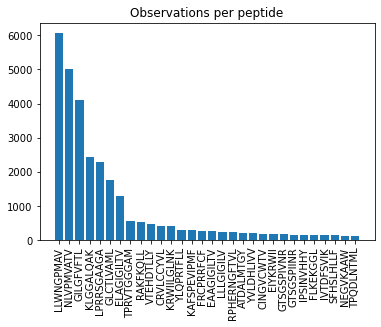

In [159]:
vc = df_unique.peptide_seq.value_counts().head(30)

vc = vc[
    vc > 10
] 

plt.bar(vc.index, vc)
plt.xticks(np.arange(len(vc)), vc.index, rotation=90)
plt.title("Observations per peptide")
plt.show()

In [160]:
df_unique.peptide_seq.value_counts().head(10)

LLWNGPMAV     6070
NLVPMVATV     5025
GILGFVFTL     4092
KLGGALQAK     2431
LPRRSGAAGA    2294
GLCTLVAML     1750
ELAGIGILTV    1289
TPRVTGGGAM     547
RAKFKQLL       518
VTEHDTLLY      472
Name: peptide_seq, dtype: int64

In [161]:
df_unique.shape

(32523, 52)

In [162]:
df_unique.peptide_source.unique()

array(['HomoSapiens', 'Melanoma', 'virus', 'SKCM', 'NSCLC',
       'Acute myeloid leukemia', 'TAA', 'HCV', 'Hepatitis C virus',
       'Epstein Barr virus (EBV)', 'EBV', 'CMV', 'Cytomegalovirus (CMV)',
       'InfluenzaA', 'Influenza', 'Human immunodeficiency virus (HIV)',
       'HIV-1', 'colorectal adenocarcinoma', 'SARS-CoV-2', 'melanoma',
       'DENV2', 'DENV3/4', 'DENV1', 'epithelial cancer', 'HTLV-1', 'YFV',
       'Yellow fever virus', 'HEV', 'Hepatitis E virus infection (cHEV)',
       'HPV', 'SaccharomycesCerevisiae', 'lung cancer',
       "Alzheimer's disease", 'Herpes simplex virus 2 (HSV2)', 'HSV-2',
       'HTLV-1 (Chronic', 'Diabetes Type 1', 'CLL'], dtype=object)

In [163]:
df_unique.peptide_source.value_counts()

CMV                                   8002
YFV                                   5850
Influenza                             3327
InfluenzaA                            3113
Cytomegalovirus (CMV)                 2091
EBV                                   2061
HomoSapiens                           1769
HIV-1                                 1430
Epstein Barr virus (EBV)               898
Human immunodeficiency virus (HIV)     799
HCV                                    502
NSCLC                                  407
Melanoma                               334
SARS-CoV-2                             333
SKCM                                   247
HTLV-1                                 179
Yellow fever virus                     178
DENV1                                  165
TAA                                    159
DENV3/4                                158
virus                                  107
Hepatitis C virus                       85
melanoma                                77
DENV2      

In [164]:
cancer_mask = df_unique.peptide_source.isin(
    [
        "HomoSapiens",
        "Melanoma",
        "colorectal adenocarcinoma",
        "lung cancer",
        "epithelial cancer",
        "Acute myeloid leukemia",
        "NSCLC",
        "SKCM",
        "melanoma",
        "CLL",
        "TAA",
    ]
)

In [165]:
df_unique[~cancer_mask].peptide_source.value_counts()

CMV                                   8002
YFV                                   5850
Influenza                             3327
InfluenzaA                            3113
Cytomegalovirus (CMV)                 2091
EBV                                   2061
HIV-1                                 1430
Epstein Barr virus (EBV)               898
Human immunodeficiency virus (HIV)     799
HCV                                    502
SARS-CoV-2                             333
HTLV-1                                 179
Yellow fever virus                     178
DENV1                                  165
DENV3/4                                158
virus                                  107
Hepatitis C virus                       85
DENV2                                   60
Herpes simplex virus 2 (HSV2)           30
Diabetes Type 1                         16
HSV-2                                   15
HEV                                      6
Hepatitis E virus infection (cHEV)       6
HPV        

In [166]:
df_unique[cancer_mask].peptide_source.str.replace("HomoSapiens", "Unknown").str.replace(
    "melanoma", "Melanoma"
).value_counts()

Unknown                      1769
Melanoma                      411
NSCLC                         407
SKCM                          247
TAA                           159
CLL                            49
colorectal adenocarcinoma      33
lung cancer                    18
Acute myeloid leukemia          6
epithelial cancer               4
Name: peptide_source, dtype: int64

In [167]:
cancer_mask.value_counts()

False    29420
True      3103
Name: peptide_source, dtype: int64

In [168]:
df_unique.loc[:, "is_cancer"] = cancer_mask

In [169]:
cancer_mask.mean()

0.09540940257663807

In [170]:
t = pd.crosstab(df_unique.dataset, cancer_mask)

In [171]:
t

peptide_source,False,True
dataset,,
10x_cancer,0,239
10x_viral,3574,0
Arakaki,1,0
Brennan,42,0
Cohen,1,0
Day,21,0
Giest,10,0
Hakeem,135,0
Hamel,3,0


In [172]:
df_unique.experiment_type.value_counts().head(30)

pMHC tetramers                                                                                                      7558
dextramer-sort, TCRb seq                                                                                            5623
tetramer-sort                                                                                                       5189
antigen-specific ex vivo proliferation                                                                              3821
antigen-loaded-targets,dextramer-sort                                                                               1816
tetramer staining                                                                                                   1046
multimer-sort                                                                                                        474
cultured-T-cells,tetramer-sort                                                                                       355
in vitro simulation with peptide

## Peptide hierarchical clustering using Levenstein distance

**Peptides are linked into a single cluster if the Levenstein (edit) distance is <= 3**


TMSFSHLFYL                                           TMSFSHLFYL
VQYLGMFPV                                   VQYLGMFPV_VQYLGMLPV
KMDYFSGQL     GMDYHNGHL_KMDYFSGQL_LMDMHNGQL_LMDYWQGQL_TMDFYQGQL
TMETIDWKV                                             TMETIDWKV
KLSELHAYI                                   KLSELHAYI_KLSELHTYI
dtype: object

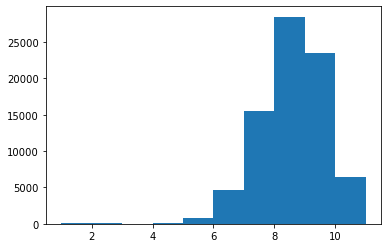

In [173]:
peptides = df_unique.peptide_seq.unique()
peptides_array = peptides.reshape(-1, 1)
dm = pdist(peptides_array, metric=lambda x, y: distance(x[0], y[0]))
plt.hist(dm)
link = linkage(dm, method="single", metric="precomputed")
clusters = fcluster(link, t=3, criterion="distance")
peptide_cluster = pd.Series(clusters, index=peptides)


cluster_name = {}
for key, group_df in peptide_cluster.groupby(peptide_cluster):
    name = "_".join(sorted(group_df.index))
    cluster_name[key] = name

peptide_to_cluster = peptide_cluster.map(cluster_name)

peptide_to_cluster.sample(5)

In [174]:
peptide_to_cluster.loc[df_all.peptide_seq].value_counts().head(20)

NLVPMVATV                                                        9732
LLWNGPMAV                                                        6809
GILGFVFTL                                                        5434
KLGGALQAK                                                        2431
GLCTLVAML                                                        2321
LPRRSGAAGA                                                       2294
AAGIGILTV_ALGIGILTV_EAAGIGILTV_ELAGIGILTV_ELAGIGLTV_LLLGIGILV    1822
TPRVTGGGAM                                                        856
CRVLCCYVL                                                         848
VTEHDTLLY                                                         682
RAKFKQLL                                                          639
KRWIILGLNK_KRWIIMGLNK                                             608
FRCPRRFCF                                                         532
KAFSPEVIPMF_RAFSPEVIPMF                                           470
RPHERNGFTV_RPHERNGFT

In [175]:
len(set(clusters)), len(peptides)

(267, 400)

In [176]:
df_all.loc[:, "peptide_cluster"] = peptide_to_cluster.loc[df_all.peptide_seq].values

In [177]:
df_unique.loc[:, "peptide_cluster"] = peptide_to_cluster.loc[df_unique.peptide_seq].values

In [178]:
df_all.to_csv("../../data/phla_tcr_all.csv.gz", index=False)

In [179]:
df_unique.to_csv("../../data/phla_tcr_unique.csv.gz", index=False)

In [180]:
df_all.shape

(43558, 53)

In [181]:
df_unique.shape

(32523, 54)